# Parsing data

## Filtering images to available images
Since we only have the subset of the full danbooru2018 from Kaggle, we first filter the metadata to the available images in our subset.

In [4]:
import json
from pathlib import Path
import os
from fastai.core import parallel
import pickle
    
def inner(pths, i):
    inner_lab = {}
    pth, image_dir = pths
    with open(pth, "r") as f:
        for line in f:
            example = json.loads(line)
            idd = example['id']
            f1 = "{:04d}".format((int(idd) % 1000))

            poth = Path(image_dir)/f1/(str(idd) + '.' + str(example['file_ext']))
            example['path'] = poth
            if poth.is_file():
                inner_lab[idd] = example
            else:
                continue
    with open(pth.parent/(pth.stem + 'tmp.pkl'), 'wb') as handle:
        pickle.dump(inner_lab, handle, protocol=pickle.HIGHEST_PROTOCOL)

def filter_labels(metadata_dir, image_dir):
    """ 
    Filters and merges all metadata in `metadata_dir` into a single json object,
    consisting of only the images you have in `image_dir`
    """
    meta_paths = Path(metadata_dir).glob('*.json')
    labels = {}
    
    col = [(pth, image_dir) for pth in meta_paths]
    parallel(inner, col)
    
    finished_paths = Path(metadata_dir).glob('*tmp.pkl')
    for pth in finished_paths:
        with open(pth, 'rb') as handle:
            labels.update(pickle.load(handle))
        os.remove(pth)
        
    
    return labels

labels = filter_labels('danbooru-metadata/', 'danbooru-images/')
print(len(labels))

254136


In [5]:
with open('filtered_labels.pkl', 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Getting CSV labels of top tags

In [6]:
import pandas as pd

meme = {'filename': [], 'tags': []}
total = len(labels)
# togos = set()
for cnt, l in enumerate(labels):
    idd = labels[l]['id']
    f1 = "{:04d}".format((int(idd) % 1000))
    if labels[l]['file_ext'] not in ['jpg', 'png']:
        continue
    poth = Path('danbooru-images/')/f1/(str(idd) + '.' + str(labels[l]['file_ext']))
    
    tags = labels[l]['tags']
    tags = [t['name'] for t in tags if t['name'] != '?']
#     togos = togos.union(set(tags))
    tags = ' '.join(tags)
    meme['filename'].append(poth)
    meme['tags'].append(tags)
    
    if cnt % 10000 == 0:
        print("{:d} of {:d} | {:3.1f}%".format(cnt, total, 100*cnt/total))

df = pd.DataFrame(meme)
df.head()

0 of 254136 | 0.0%
10000 of 254136 | 3.9%
20000 of 254136 | 7.9%
30000 of 254136 | 11.8%
40000 of 254136 | 15.7%
50000 of 254136 | 19.7%
60000 of 254136 | 23.6%
70000 of 254136 | 27.5%
80000 of 254136 | 31.5%
90000 of 254136 | 35.4%
100000 of 254136 | 39.3%
110000 of 254136 | 43.3%
120000 of 254136 | 47.2%
130000 of 254136 | 51.2%
140000 of 254136 | 55.1%
150000 of 254136 | 59.0%
160000 of 254136 | 63.0%
170000 of 254136 | 66.9%
180000 of 254136 | 70.8%
190000 of 254136 | 74.8%
200000 of 254136 | 78.7%
210000 of 254136 | 82.6%
220000 of 254136 | 86.6%
230000 of 254136 | 90.5%
240000 of 254136 | 94.4%
250000 of 254136 | 98.4%


,filename,tags
0,danbooru-images/0005/184005.jpg,1girl animal_ears chibi cow_ears cow_girl dres...
1,danbooru-images/0129/284129.jpg,1girl artist_request blonde_hair blue_eyes elf...
2,danbooru-images/0075/2303075.jpg,1girl asashio_(kantai_collection) breast_hold ...
3,danbooru-images/0084/2272084.jpg,4girls akashi_(kantai_collection) anchorage_wa...
4,danbooru-images/0037/2616037.jpg,1boy 1girl anger_vein comic dress greyscale ha...


In [7]:
df.to_csv('tag_labels_all.csv', index=False)

In [8]:
df = pd.read_csv('tag_labels_all.csv')
total_cnt = pd.Series(' '.join(df['tags']).lower().split()).value_counts()
def filter_to_tags(dataframe, tags):
    total = len(dataframe)
    for index, row in dataframe.iterrows():
        if row.isna().sum() > 0:
            print("Detected na row {:}, skipping".format(row))
            continue
        
        tmp = row['tags'].lower().split()
        tmp = [t for t in tmp if t in tags]

        row['tags'] = ' '.join(tmp)
        if index % 20000 == 0:
            print("{:d} of {:d} | {:3.1f}%".format(index, total, 100*index/total))
    
    print("Total na = ", dataframe.isna().sum())
    dataframe = dataframe.dropna(axis=0)
    
    return dataframe

print("Total unique labels = ", len(total_cnt))

df2 = filter_to_tags(df.copy(), total_cnt[0:100])
df2.to_csv('tag_labels_100.csv', index=False)
df3 = filter_to_tags(df.copy(), total_cnt[0:200])
df3.to_csv('tag_labels_200.csv', index=False)
df4 = filter_to_tags(df.copy(), total_cnt[0:500])
df4.to_csv('tag_labels_500.csv', index=False)

Total unique labels =  118017
0 of 254136 | 0.0%
20000 of 254136 | 7.9%
40000 of 254136 | 15.7%
60000 of 254136 | 23.6%
80000 of 254136 | 31.5%
100000 of 254136 | 39.3%
120000 of 254136 | 47.2%
140000 of 254136 | 55.1%
160000 of 254136 | 63.0%
180000 of 254136 | 70.8%
200000 of 254136 | 78.7%
220000 of 254136 | 86.6%
240000 of 254136 | 94.4%
Total na =  filename    0
tags        0
dtype: int64
0 of 254136 | 0.0%
20000 of 254136 | 7.9%
40000 of 254136 | 15.7%
60000 of 254136 | 23.6%
80000 of 254136 | 31.5%
100000 of 254136 | 39.3%
120000 of 254136 | 47.2%
140000 of 254136 | 55.1%
160000 of 254136 | 63.0%
180000 of 254136 | 70.8%
200000 of 254136 | 78.7%
220000 of 254136 | 86.6%
240000 of 254136 | 94.4%
Total na =  filename    0
tags        0
dtype: int64
0 of 254136 | 0.0%
20000 of 254136 | 7.9%
40000 of 254136 | 15.7%
60000 of 254136 | 23.6%
80000 of 254136 | 31.5%
100000 of 254136 | 39.3%
120000 of 254136 | 47.2%
140000 of 254136 | 55.1%
160000 of 254136 | 63.0%
180000 of 254136 | 70.

In [16]:
df = pd.read_csv('tag_labels_100.csv')
df = df.dropna(axis=0)
df.to_csv('tag_labels_100.csv', index=False)

In [1]:
from fastai import *
from fastai.vision import *

path = './'

arch = models.resnet18
src = ImageList.from_csv(path, 'tag_labels_100.csv').split_by_rand_pct(0.1, seed=15)

In [2]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.15, max_warp=0.1)

def get_data(bs, size, prev_data=None):
    if prev_data == None:
        data = (src.label_from_df(label_delim=' ')
               .transform(tfms, size=size)
               .databunch(bs=bs).normalize())
    else:
        print("Using stats ", prev_data.stats)
        data = (src.label_from_df(label_delim=' ')
               .transform(tfms, size=size)
               .databunch(bs=bs).normalize(prev_data.stats))
    return data

In [19]:
data = get_data(512, 64)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


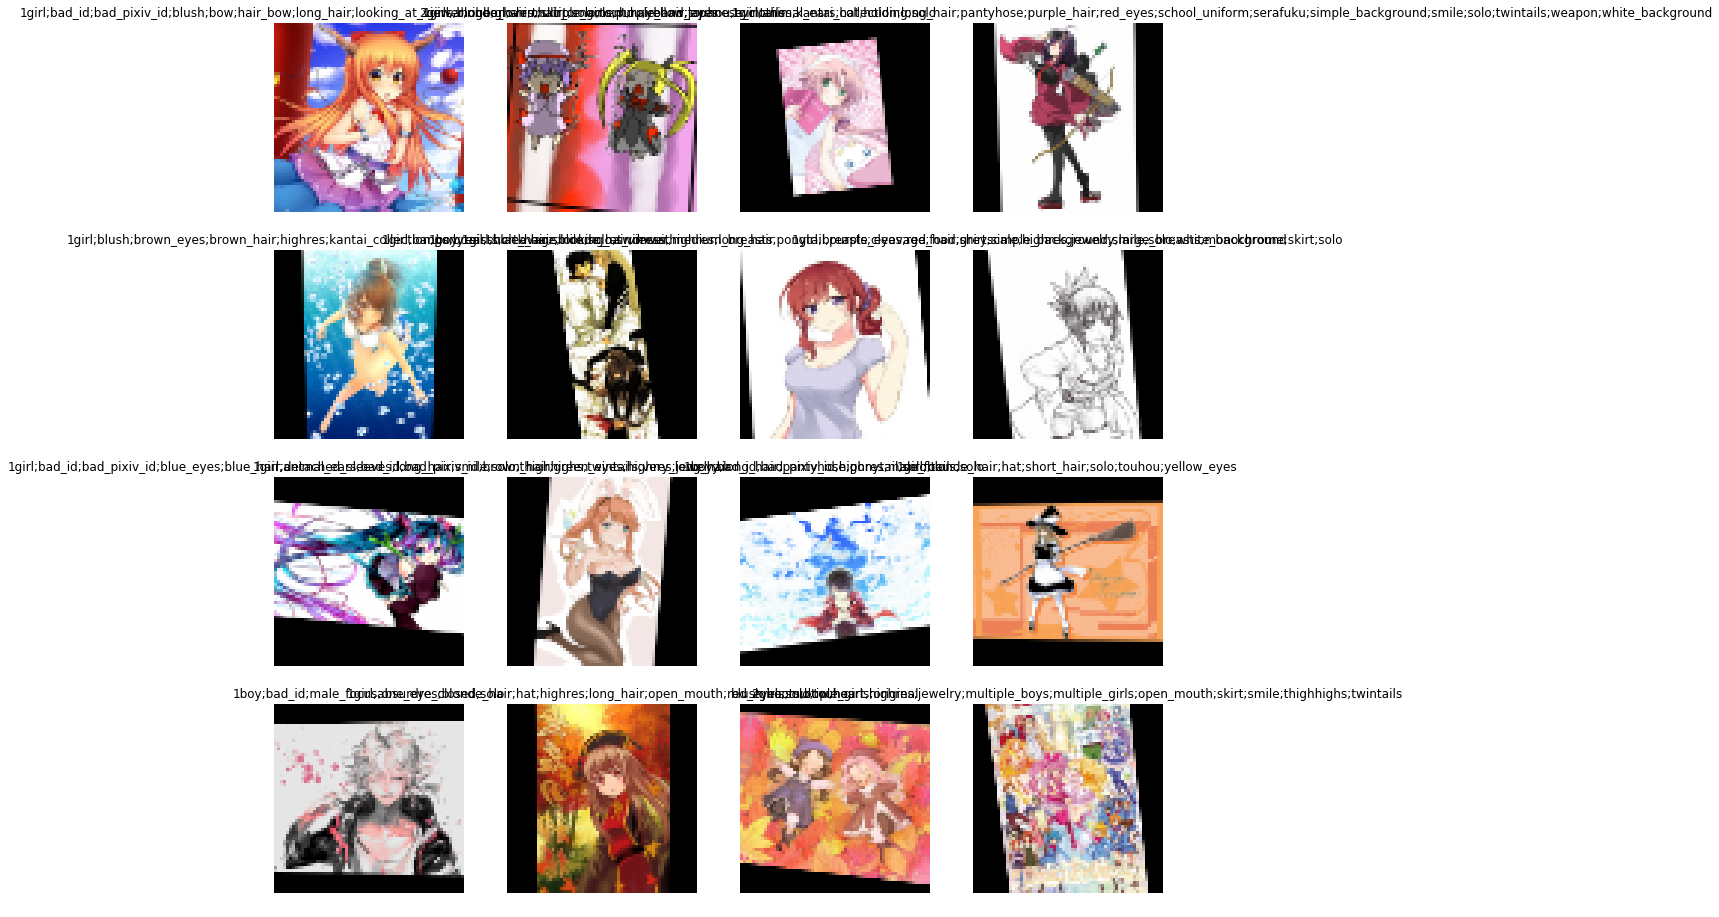

In [20]:
data.show_batch(rows=4)

In [9]:
acc_04 = partial(accuracy_thresh, thresh=0.4)
f_score = partial(fbeta, thresh=0.4)
acc_02 = partial(accuracy_thresh, thresh=0.2)

learn = cnn_learner(data, arch, pretrained=False, metrics=[f_score, acc_04, acc_02]).load('1c')
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


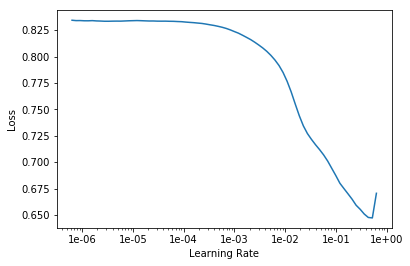

In [25]:
learn.lr_find()
learn.recorder.plot()

In [4]:
import os, functools, traceback, gc, sys

def is_in_ipython():
    "Is the code running in the ipython environment (jupyter including)"

    program_name = os.path.basename(os.getenv('_', ''))

    if ('jupyter-notebook' in program_name or # jupyter-notebook
        'ipython'          in program_name or # ipython
        'JPY_PARENT_PID'   in os.environ):    # ipython-notebook
        return True
    else:
        return False

IS_IN_IPYTHON = is_in_ipython()

def is_in_colab():
    "Is the code running in Google Colaboratory?"
    if not IS_IN_IPYTHON: return False
    try:
        from google import colab
        return True
    except: return False

IS_IN_COLAB = is_in_colab()

def get_ref_free_exc_info():
    "Free traceback from references to locals() in each frame to avoid circular reference leading to gc.collect() unable to reclaim memory"
    type, val, tb = sys.exc_info()
    traceback.clear_frames(tb)
    return (type, val, tb)

def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        tb_clear_frames = os.environ.get('FASTAI_TB_CLEAR_FRAMES', None)
        if not IS_IN_IPYTHON or tb_clear_frames=="0":
            return func(*args, **kwargs)

        try:
            return func(*args, **kwargs)
        except Exception as e:
            if ("CUDA out of memory" in str(e) or
                "device-side assert triggered" in str(e) or
                tb_clear_frames == "1"):
                type, val, tb = get_ref_free_exc_info() # must!
                gc.collect()
                if "device-side assert triggered" in str(e):
                    warn("""When 'device-side assert triggered' error happens, it's not possible to recover and you must restart the kernel to continue. Use os.environ['CUDA_LAUNCH_BLOCKING']="1" before restarting to debug""")
                raise type(val).with_traceback(tb) from None
            else: raise # re-raises the exact last exception
    return wrapper

class gpu_mem_restore_ctx():
    "context manager to reclaim RAM if an exception happened under ipython"
    def __enter__(self): return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        if not exc_val: return True
        traceback.clear_frames(exc_tb)
        gc.collect()
        raise exc_type(exc_val).with_traceback(exc_tb) from None

In [6]:
@gpu_mem_restore
def do_fit(lll, save_name, lrs, pct_start=0.4):
    lll.fit_one_cycle(1, lrs, pct_start=pct_start)
    lll.save(save_name)
    lll.show_results(rows=1, imgsize=8)

In [29]:
lr = 1e-1
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.316930,0.318717,0.183875,0.889966,45:26
1,0.300051,0.299678,0.226700,0.893175,46:17
2,0.290580,0.289195,0.254504,0.895813,46:40


In [47]:
data = get_data(512, 128, prev_data=learn.data)
learn.data = data
gc.collect()

Using stats  [tensor([0.5293, 0.4973, 0.4939]), tensor([0.3994, 0.3882, 0.3874])]


0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


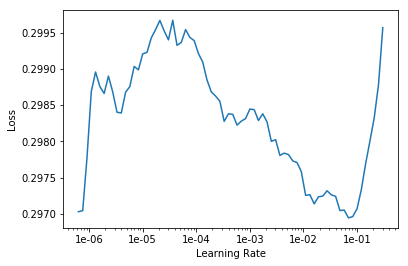

In [49]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.292869,0.291195,0.248971,0.895146,52:17
1,0.288574,0.294082,0.253873,0.896148,52:42
2,0.287335,0.285862,0.263450,0.896402,53:13
3,0.285590,0.283882,0.268090,0.896937,54:09
4,0.284334,0.283548,0.272840,0.896775,54:58


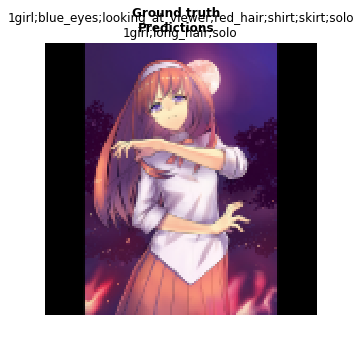

In [51]:
do_fit(learn, '1b', slice(1e-2))

In [3]:
data = get_data(350, 256, prev_data=learn.data)
learn.data = data
gc.collect()

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.285309,0.293173,0.273769,0.896790,59:39
1,0.282794,0.281852,0.277907,0.897910,1:00:01
2,0.282047,0.279331,0.282733,0.897984,1:00:34


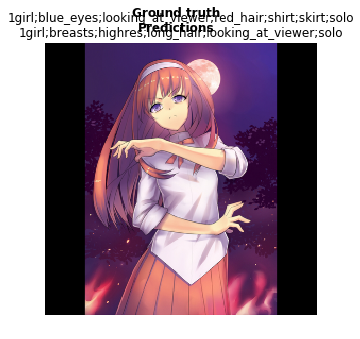

In [12]:
do_fit(learn, '1c', slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,accuracy_thresh,time
0,0.281557,0.283069,0.268243,0.897543,0.854770,2:00:14


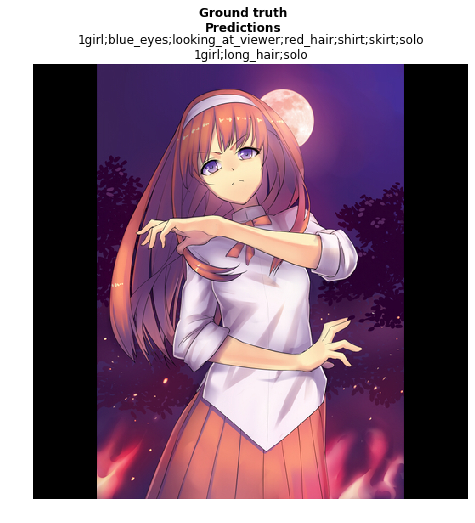

In [18]:
# data = get_data(128, 512, prev_data=learn.data)
# learn.data = data
gc.collect()
learn.data.batch_size=90
learn.load('1c')
gc.collect()
do_fit(learn, '1d', slice(1e-3))
# learn.lr_find()
# learn.recorder.plot()

In [19]:
learn.export('resnet18.pkl')

In [26]:
norm_consts = {'mean': learn.data.stats[0].tolist(), 'std': learn.data.stats[1].tolist()}

In [27]:
norm_consts

{'mean': [0.5422357320785522, 0.5034515261650085, 0.49635425209999084],
 'std': [0.40316540002822876, 0.39340198040008545, 0.3892141580581665]}

In [28]:
import json

In [30]:
with open('danbooru_stats.json', 'w') as f:
    f.write(json.dumps(norm_consts))

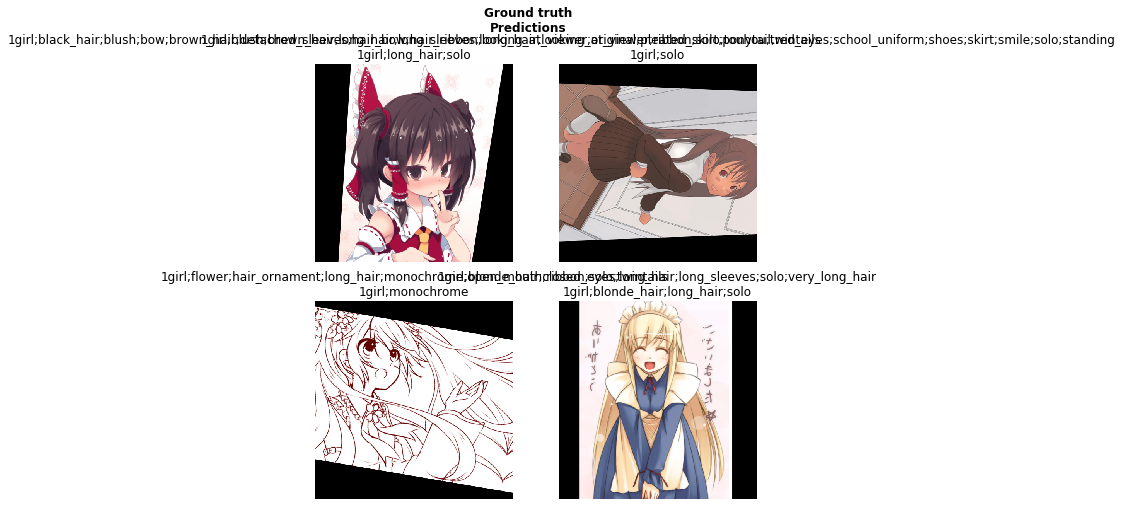

In [33]:
learn.show_results(ds_type=DatasetType.Train, rows=2)